In [1]:
import numpy as np
import pandas as pd
import os


<div style="color:#D81F26;
           display:fill;
           border-style: solid;
           border-color:#C1C1C1;
           font-size:14px;
           font-family:Calibri;
           background-color:#373737;">
<h2 style="text-align: center;
           padding: 10px;
           color:#FFFFFF;">
======= ICR - Identifying Age-Related Conditions  =======
</h2>
</div>

## 1.1. Library Setup

In [3]:
!pip install category_encoders imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.1 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import random
from scipy.stats import uniform, randint

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn import metrics

from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif

import category_encoders as encoders
from sklearn.preprocessing import LabelEncoder, RobustScaler

from imblearn.over_sampling import SMOTE

## 1.2. Load the Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Read the train, test and greeks data

df_train = pd.read_csv("drive/MyDrive/230814/icr-identify-age-related-conditions/train.csv")
df_test = pd.read_csv("drive/MyDrive/230814/icr-identify-age-related-conditions/test.csv")
df_greeks = pd.read_csv("drive/MyDrive/230814/icr-identify-age-related-conditions/greeks.csv")

print('No. of records for train : {}'.format(df_train.shape))
print('No. of records for test : {}'.format(df_test.shape))
print('No. of records for greeks : {}'.format(df_greeks.shape))

No. of records for train : (617, 58)
No. of records for test : (5, 57)
No. of records for greeks : (617, 6)


# 2. EDA

# 2.1. Distribution of Target Label
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">

Text(0.5, 1.0, 'Distribution of Target Label (i.e. Class)')

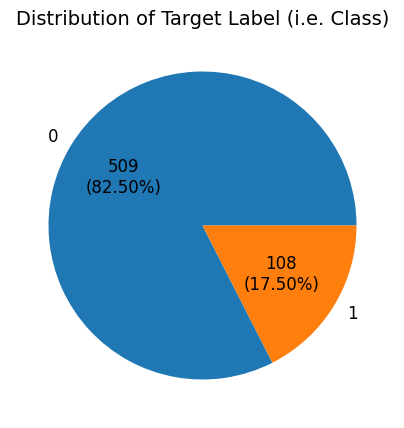

In [7]:
plt.figure(figsize=(5,5))

def auto_fmt (pct_value):
    return '{:.0f}\n({:.2f}%)'.format(df_train['Class'].value_counts().sum()*pct_value/100,pct_value)

df_transported_count = df_train['Class'].value_counts().rename_axis('Class').reset_index(name='Counts')

fig = plt.gcf()
plt.pie(x=df_transported_count['Counts'], labels=df_transported_count['Class'], autopct=auto_fmt, textprops={'fontsize': 12})
plt.title('Distribution of Target Label (i.e. Class)',  fontsize = 14)

# 2.2. Missing Value Analysis
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">

</div>

In [8]:
# Only include numerical features
df_train_numerical = df_train.drop(['Id', 'EJ', 'Class'], axis=1)

<Figure size 1000x600 with 0 Axes>

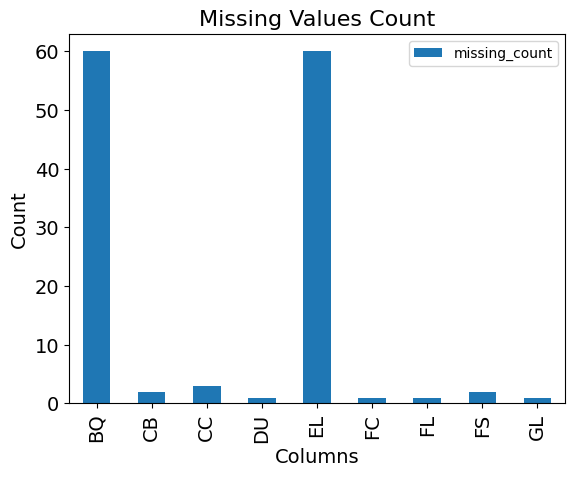

In [9]:
plt.figure(figsize=(10, 6))

df_train_missing = df_train_numerical.isna().sum()
df_train_missing = df_train_missing.reset_index()

df_train_missing.columns = ['feature', 'missing_count']

df_train_missing = df_train_missing.loc[df_train_missing['missing_count'] > 0]

df_train_missing.plot.bar(x='feature', y='missing_count')

plt.title('Missing Values Count', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)

plt.show()


# 2.3. Descritpive Analysis
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">

Descriptive analysis refers to the process of summarizing and interpreting data to gain insights and understand its main characteristics. It involves the use of various statistical measures and visualization techniques to describe and present data in a meaningful way.
</div>

In [10]:
df_train_numerical.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
AB,617.0,0.477149,0.468388,0.081187,0.252107,0.354659,0.559763,6.161666
AF,617.0,3502.013221,2300.322717,192.593280,2197.345480,3120.318960,4361.637390,28688.187660
AH,617.0,118.624513,127.838950,85.200147,85.200147,85.200147,113.739540,1910.123198
AM,617.0,38.968552,69.728226,3.177522,12.270314,20.533110,39.139886,630.518230
AR,617.0,10.128242,10.518877,8.138688,8.138688,8.138688,8.138688,178.943634
AX,617.0,5.545576,2.551696,0.699861,4.128294,5.031912,6.431634,38.270880
AY,617.0,0.060320,0.416817,0.025578,0.025578,0.025578,0.036845,10.315851
AZ,617.0,10.566447,4.350645,3.396778,8.129580,10.461320,12.969516,38.971568
BC,617.0,8.053012,65.166943,1.229900,1.229900,1.229900,5.081244,1463.693448
BD,617.0,5350.388655,3021.326641,1693.624320,4155.702870,4997.960730,6035.885700,53060.599240


# 2.4. Histogram Analysis for Skewness
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
It examines the shape of the distribution displayed in a histogram to determine the skewness of the data.
</div>

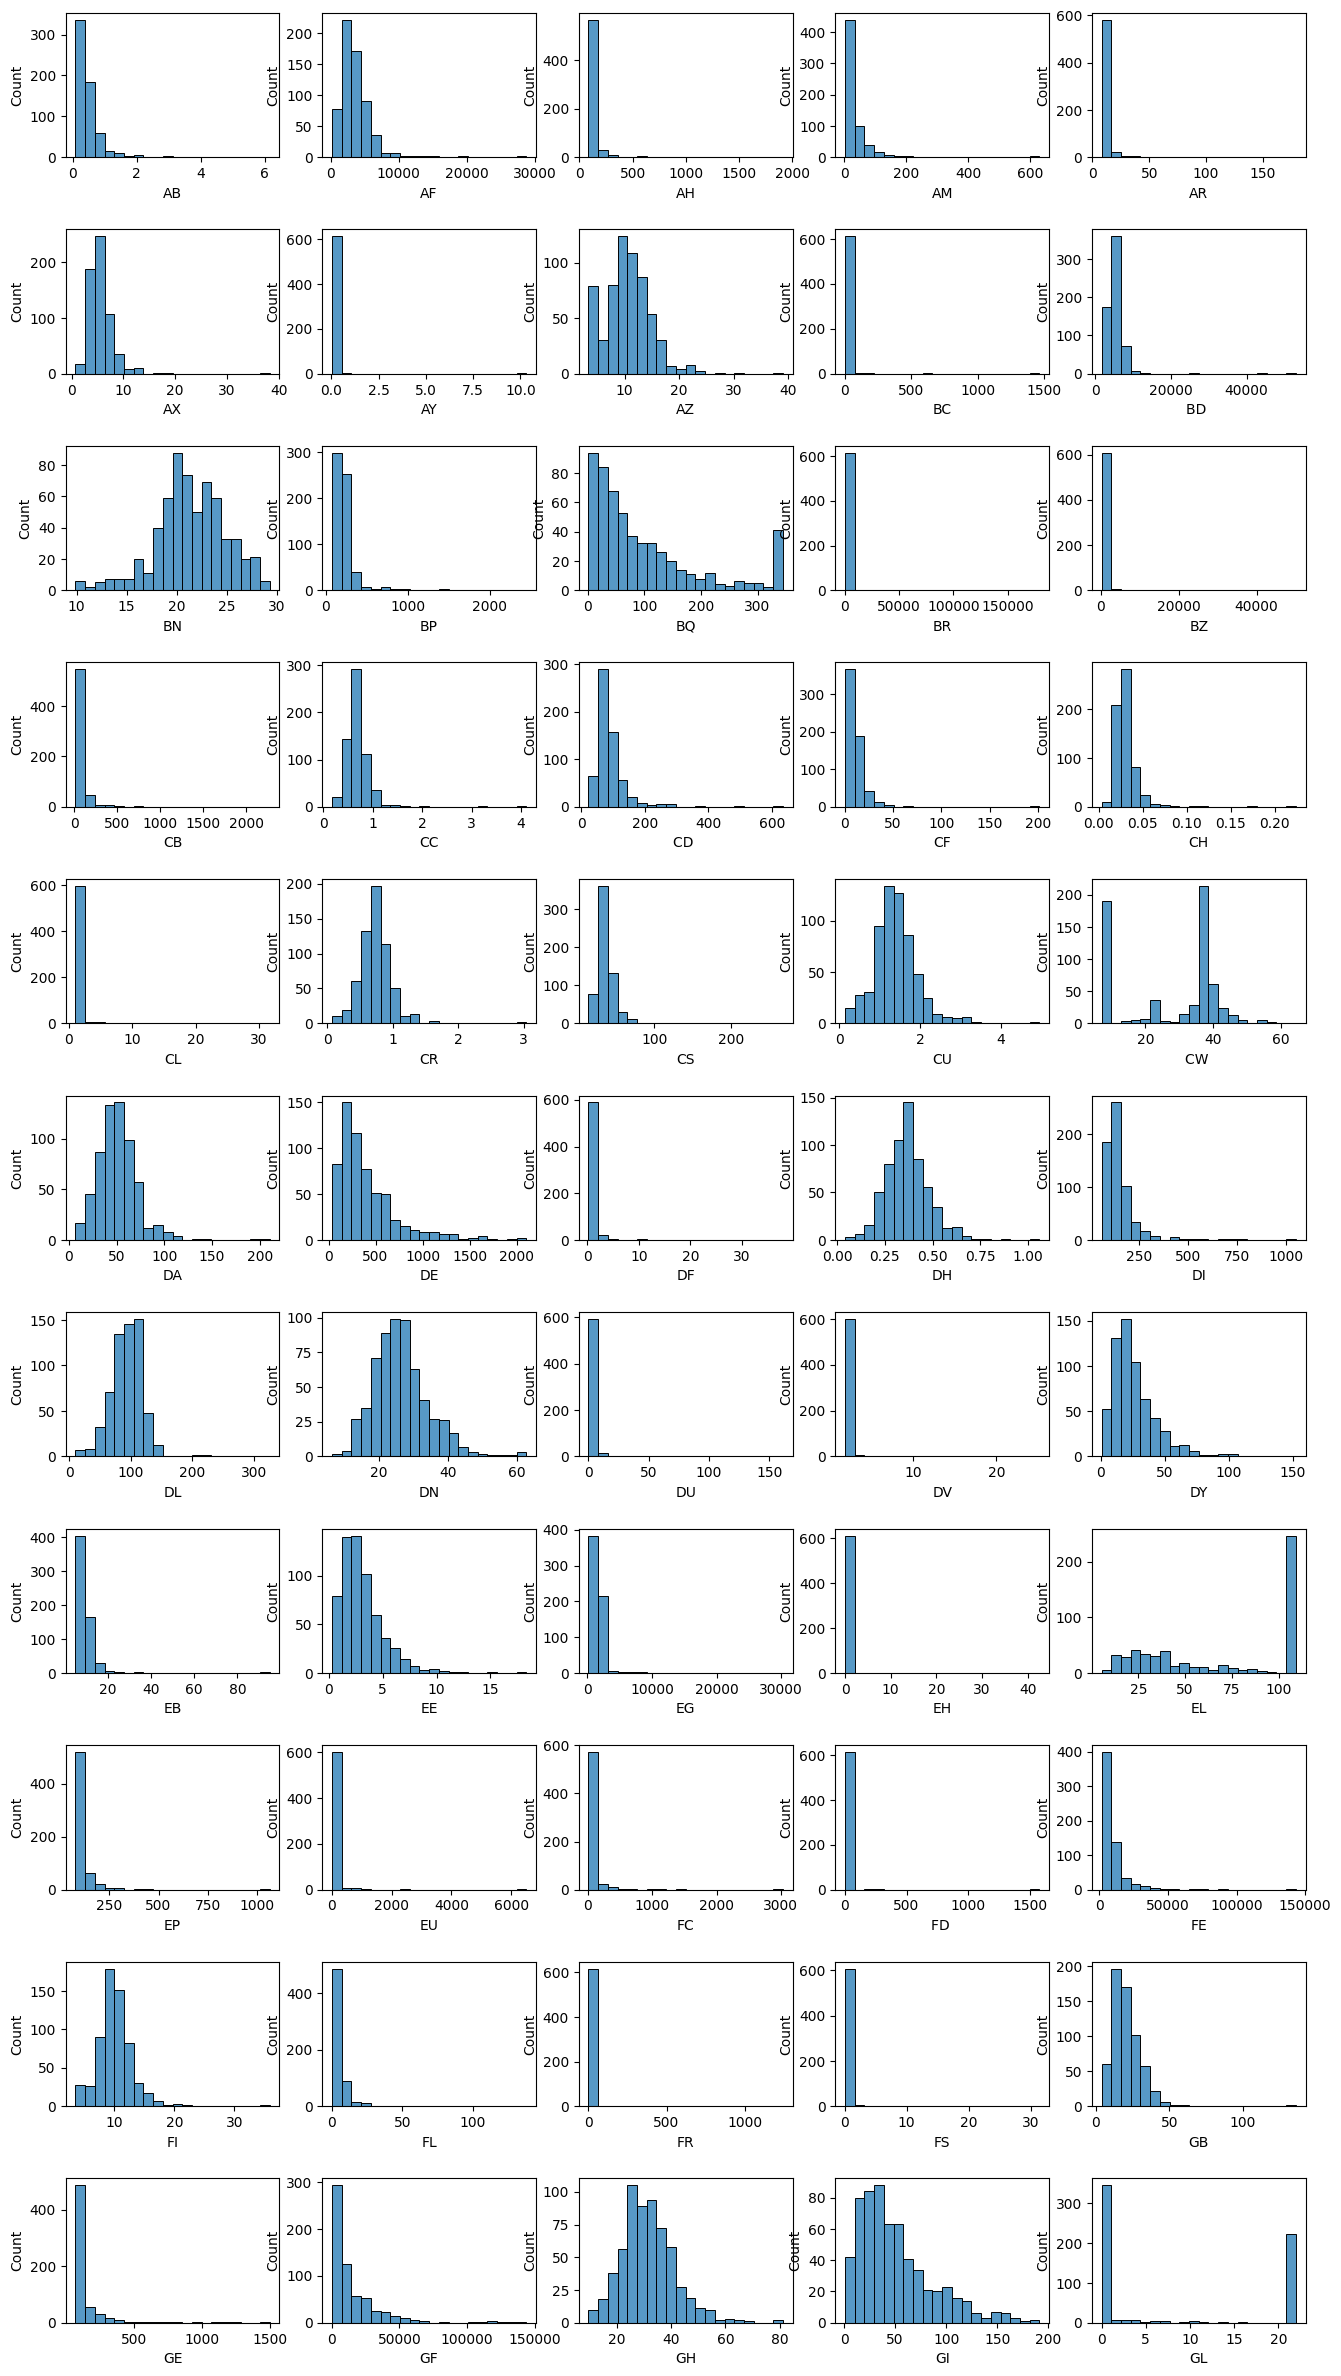

In [11]:
# Histgram for numercial features
fig, ax = plt.subplots(11, 5, figsize=(16,30))

for i in range(0, (len(ax.flatten()))):
#     print('{}, {}'.format(int(i/5),i % 5))
    sns.histplot(data=df_train_numerical, x =df_train_numerical.iloc[:,i], bins=20, ax=ax[int(i/5),i % 5])
#     ax[int(i/5), i % 5].set_title(df_train_numerical.columns[i])

# Adjust the vertical spacing between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()

# 2.5. Boxplot Analysis for Outliers
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
It identifies and analyzes outliers in a dataset. A boxplot is a graphical representation that displays the distribution of data and provides insights into the presence of outliers. Here's how you can perform boxplot analysis for outliers
</div>

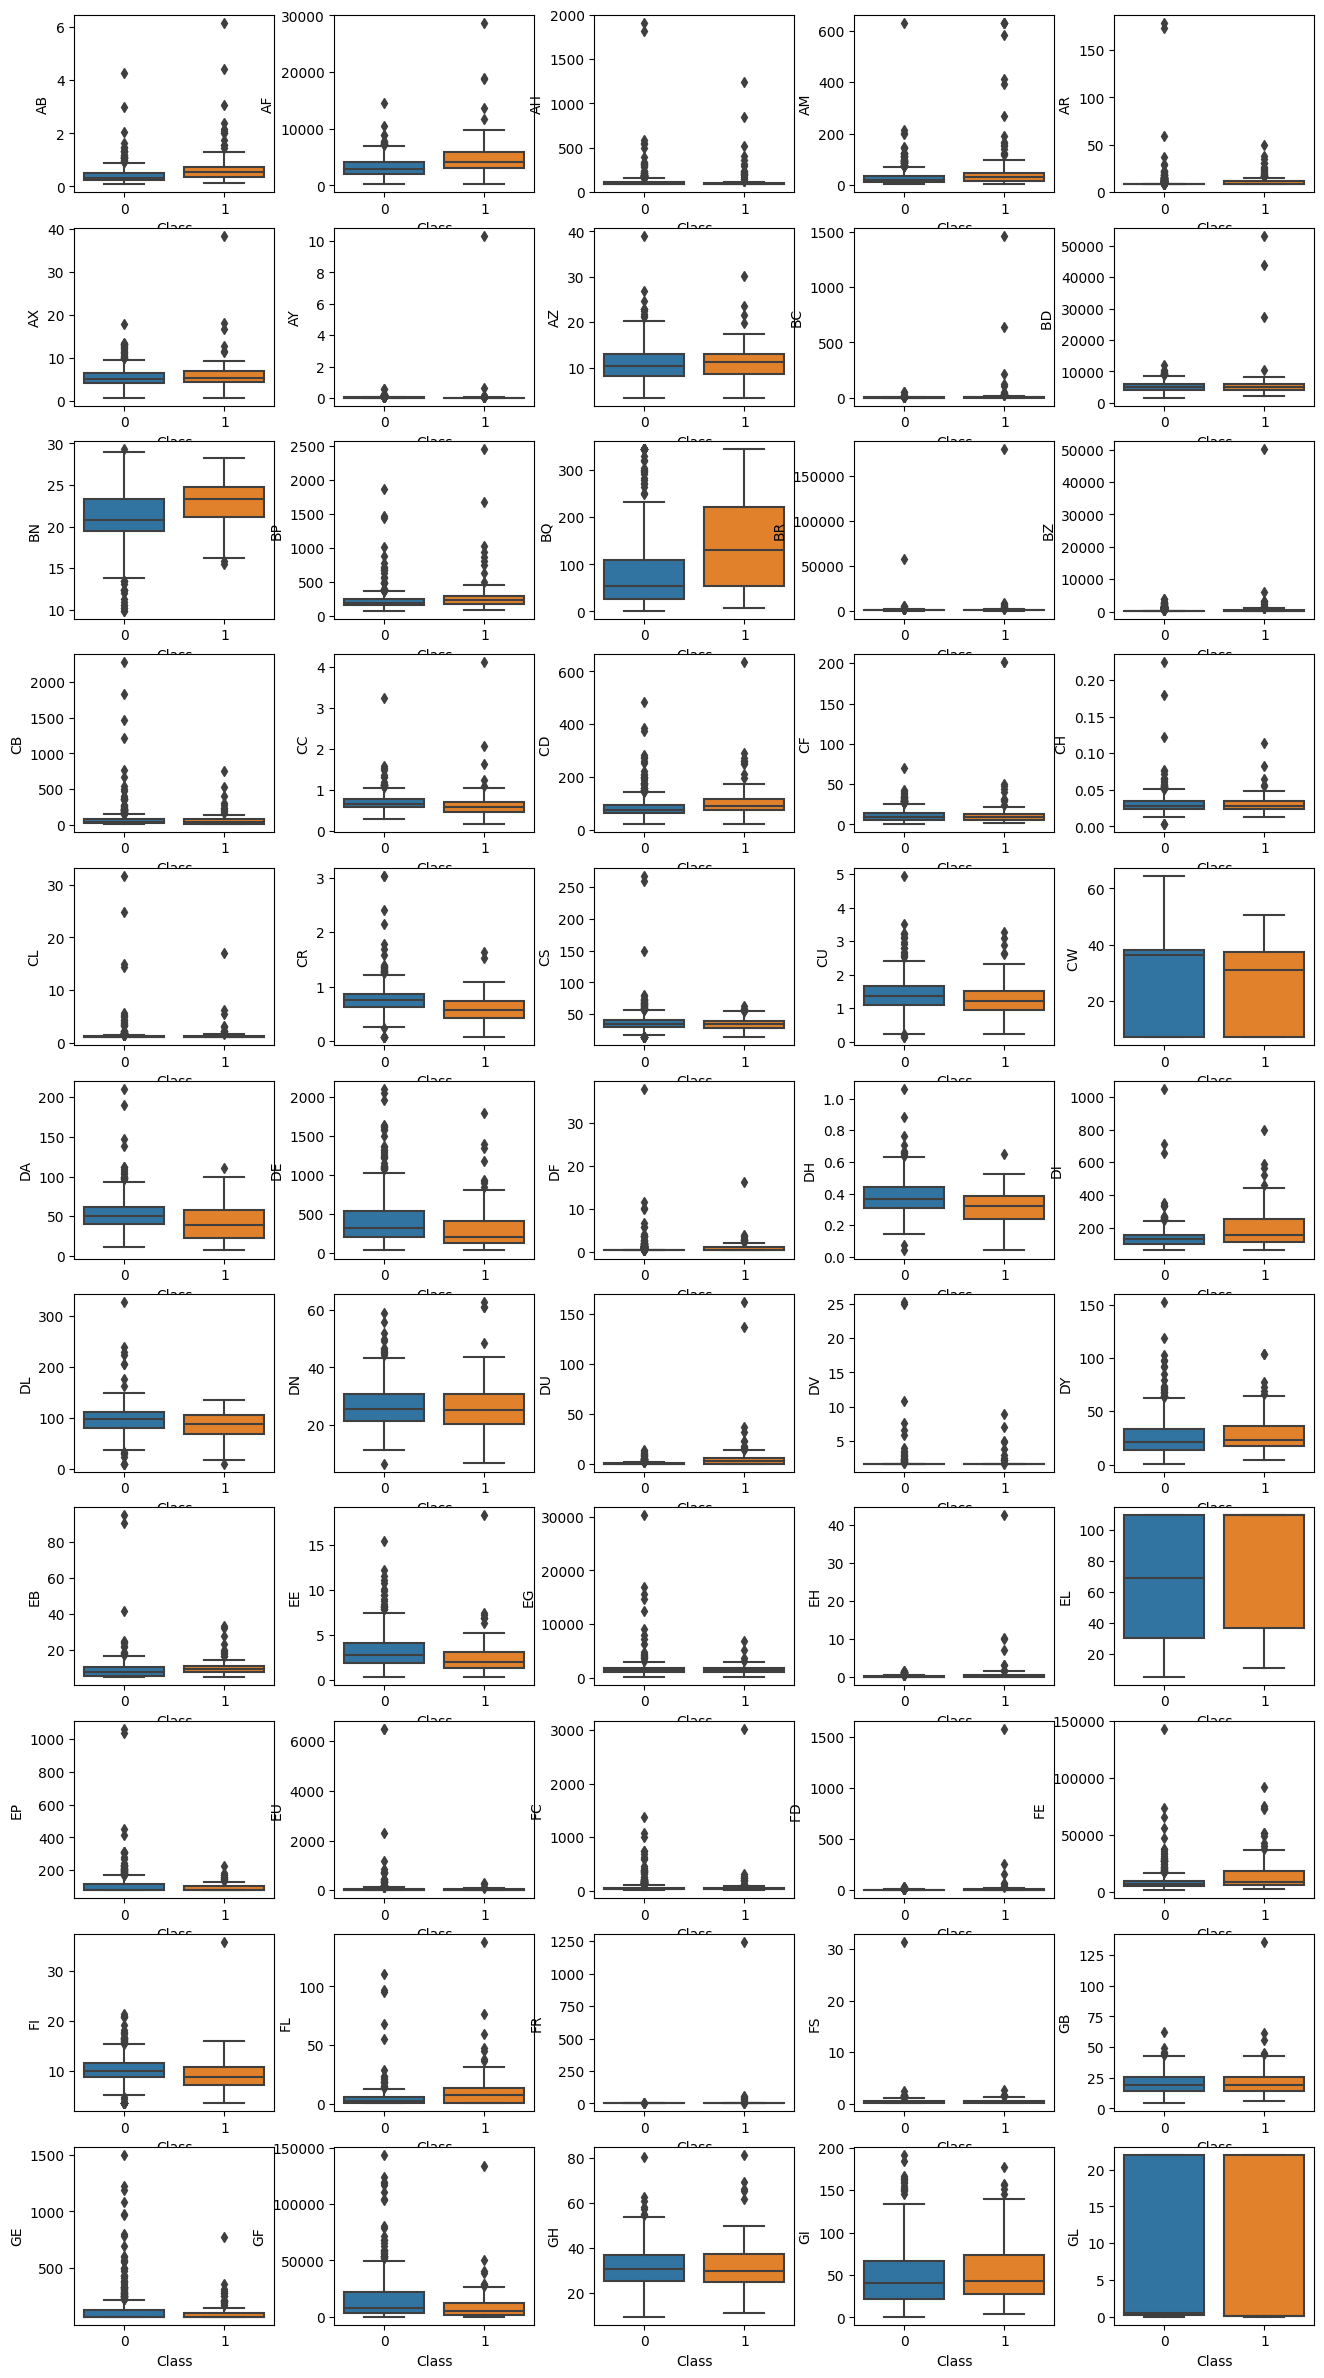

In [12]:
# Histgram for numercial features
fig, ax = plt.subplots(11, 5, figsize=(16,30))

for i in range(0, (len(ax.flatten()))):
    sns.boxplot(x="Class",y=df_train_numerical.columns[i],data=df_train, ax=ax[int(i/5),i % 5])

plt.subplots_adjust(wspace=0.3)
plt.show()

# 2.6. Count Plot for Distribution of Categorical Features
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">

</div>

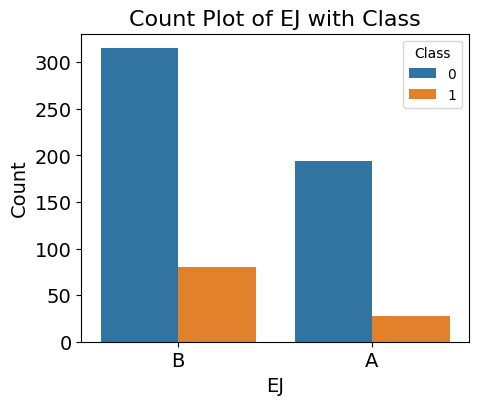

In [13]:
plt.figure(figsize=(5, 4))
plt.legend(fontsize=13)

sns.countplot(data=df_train, x='EJ', hue='Class')

plt.xlabel('EJ', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count Plot of EJ with Class', fontsize=16)

plt.tick_params(axis='x', which='major', labelsize=14)
plt.tick_params(axis='y', which='major', labelsize=14)

plt.legend(title='Class')

plt.show()

# 3. Data Pre-processing for Model Data

# 3.1. Missing Value Imputation - kNN Imputer
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
</div>


In [14]:
imputer = KNNImputer(n_neighbors=5)

df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train[df_train_numerical.columns]), columns=df_train_numerical.columns)
df_test_imputed =pd.DataFrame(imputer.transform(df_test[df_train_numerical.columns]), columns=df_train_numerical.columns)

In [15]:
df_train_null = df_train_imputed[df_train_imputed.isnull().any(axis=1)]
df_test_null = df_test_imputed[df_test_imputed.isnull().any(axis=1)]

print('No. of records with missing value in Train data set after Imputation : {}'.format(df_train_null.shape[0]))
print('No. of records with missing value in Test data set after Imputation : {}'.format(df_test_null.shape[0]))

print('=' * 50)
print('Shape of the Train data set : {}'.format(df_train_imputed.shape))
print('Shape of the Test data set : {}'.format(df_test_imputed.shape))

No. of records with missing value in Train data set after Imputation : 0
No. of records with missing value in Test data set after Imputation : 0
Shape of the Train data set : (617, 55)
Shape of the Test data set : (5, 55)


In [16]:
df_train_2 = df_train.drop(df_train_numerical.columns, axis=1)
df_train_2 = pd.concat ([df_train_2, df_train_imputed], axis=1)

df_test_2 = df_test.drop(df_train_numerical.columns, axis=1)
df_test_2 = pd.concat ([df_test_2, df_test_imputed], axis=1)

print('Shape of the Train data set : {}'.format(df_train_2.shape))
print('Shape of the Test data set : {}'.format(df_test_2.shape))


Shape of the Train data set : (617, 58)
Shape of the Test data set : (5, 57)


# 3.2. Data Standarization for Numercial Features
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
</div>

In [17]:
scaler = RobustScaler()

index = df_train_2.index

scaler_train = scaler.fit_transform(df_train_2[df_train_numerical.columns])
scaler_df_train = pd.DataFrame(scaler_train, columns=df_train_numerical.columns)

scaler_df_train.index = index
print('Shape of Scaled Train Data Set: {}'.format(scaler_df_train.shape))


index = df_test_2.index

scaler_test = scaler.transform(df_test_2[df_train_numerical.columns])
scaler_df_test = pd.DataFrame(scaler_test, columns=df_train_numerical.columns)

scaler_df_test.index = index
print('Shape of Scaled Test Data Set: {}'.format(scaler_df_test.shape))

Shape of Scaled Train Data Set: (617, 55)
Shape of Scaled Test Data Set: (5, 55)


In [18]:
df_train_2 = df_train_2.drop(df_train_numerical.columns, axis=1)
df_train_2 = pd.concat ([df_train_2, scaler_df_train], axis=1)

df_test_2 = df_test_2.drop(df_train_numerical.columns, axis=1)
df_test_2 = pd.concat ([df_test_2, scaler_df_test], axis=1)

print('Shape of the Train data set : {}'.format(df_train_2.shape))
print('Shape of the Test data set : {}'.format(df_test_2.shape))


Shape of the Train data set : (617, 58)
Shape of the Test data set : (5, 57)


# 3.3. Data Encoding for Categorical Features
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
</div>

In [19]:
CATBoostENCODE = encoders.CatBoostEncoder()

categorical_cols = ['EJ']

encoder_train = CATBoostENCODE.fit_transform(df_train[categorical_cols], df_train['Class'])
encoded_df_train = pd.DataFrame(encoder_train)
print('Shape of the Encoded Train Data Set: {}'.format(encoded_df_train.shape))

encoder_test = CATBoostENCODE.transform(df_test[categorical_cols])
encoded_df_test = pd.DataFrame(encoder_test)
print('Shape of the Encoded Test Data Set: {}'.format(encoded_df_test.shape))

Shape of the Encoded Train Data Set: (617, 1)
Shape of the Encoded Test Data Set: (5, 1)


In [20]:
df_train_2 = df_train_2.drop(categorical_cols, axis=1)
df_train_2 = pd.concat ([df_train_2, encoded_df_train], axis=1)

df_test_2 = df_test_2.drop(categorical_cols, axis=1)
df_test_2 = pd.concat ([df_test_2, encoded_df_test], axis=1)

print('Shape of the Train data set : {}'.format(df_train_2.shape))
print('Shape of the Test data set : {}'.format(df_test_2.shape))

Shape of the Train data set : (617, 58)
Shape of the Test data set : (5, 57)


# 3.4. SelectKBest Method from SKLearn for Feature Selection
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
</div>

In [21]:
train = df_train_2.drop(['Id', 'Class'], axis=1)
test = df_train_2['Class']

test.columns = ['Class']


In [22]:
threshold = 0.1
t_score = 5

fs = SelectKBest(score_func=f_classif, k=len(train.columns))

X_selected = fs.fit_transform(train, test.values)
print('Befoe the SelectKBest = {}'.format(train.shape))

new_features = [] # The list of features less than the p-values
drop_features = [] # The list of features higher than the p-values

for i in range(len(train.columns)):
    print('Feature {}: {:.3f} with p-value {:.3f}'.format(train.columns[i], fs.scores_[i], fs.pvalues_[i]))
    if fs.pvalues_[i] <= threshold and fs.scores_[i] >= t_score:
        new_features.append(train.columns[i])
    else:
        drop_features.append(train.columns[i])

X_selected_final =  pd.DataFrame(X_selected)
X_selected_final.columns = train.columns
X_selected_final = X_selected_final[new_features]
print('=' * 30)
print('After the SelectKBest = {}'.format(X_selected_final.shape))
print('Drop-out Features = {}'.format(len(drop_features)))


Befoe the SelectKBest = (617, 56)
Feature AB: 52.566 with p-value 0.000
Feature AF: 62.007 with p-value 0.000
Feature AH: 1.228 with p-value 0.268
Feature AM: 37.314 with p-value 0.000
Feature AR: 2.560 with p-value 0.110
Feature AX: 5.917 with p-value 0.015
Feature AY: 4.206 with p-value 0.041
Feature AZ: 0.112 with p-value 0.738
Feature BC: 15.316 with p-value 0.000
Feature BD : 7.839 with p-value 0.005
Feature BN: 25.169 with p-value 0.000
Feature BP: 15.600 with p-value 0.000
Feature BQ: 50.639 with p-value 0.000
Feature BR: 4.861 with p-value 0.028
Feature BZ: 7.872 with p-value 0.005
Feature CB: 0.131 with p-value 0.717
Feature CC: 1.517 with p-value 0.219
Feature CD : 18.593 with p-value 0.000
Feature CF: 7.498 with p-value 0.006
Feature CH: 0.041 with p-value 0.840
Feature CL: 0.175 with p-value 0.676
Feature CR: 33.582 with p-value 0.000
Feature CS: 1.387 with p-value 0.239
Feature CU: 4.285 with p-value 0.039
Feature CW : 2.423 with p-value 0.120
Feature DA: 26.873 with p-val

In [23]:
train = train.drop(drop_features, axis=1)
df_train_2  = df_train_2.drop(drop_features, axis=1)
df_test_2  = df_test_2.drop(drop_features, axis=1)


# 3.5. Oversampling with SMOTE (Synthetic Minority Over-sampling Technique)
<div style=" background-color:#4b371c;text-align:left; padding: 13px 13px; border-radius: 8px; color: white; font-size: 16px">
</div>

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.3)

print('Shape of train : {}'.format(X_train.shape))
print('Shape of test : {}'.format(X_test.shape))
print('='*50)
print('Shape of df_train (incl. ID and Class): {}'.format(df_train_2.shape))
print('Shape of df_test (incl. ID): {}'.format(df_test_2.shape))

Shape of train : (431, 28)
Shape of test : (186, 28)
Shape of df_train (incl. ID and Class): (617, 30)
Shape of df_test (incl. ID): (5, 29)


In [25]:
smote = SMOTE(sampling_strategy={0: 360, 1: 360})

X_smote, y_smote = smote.fit_resample(X_train, y_train)
print("length of original data is ",len(df_train_2))
print("Proportion of True data in original data is {:.2%}".format(len(y_train[y_train==1])/len(y_train)))
print("Proportion of False data in original data is {:.2%}".format(len(y_train[y_train==0])/len(y_train)))
print("length of oversampled data is ",len(X_smote))
print("Proportion of True data in oversampled data is {:.2%}".format(len(y_smote[y_smote ==1])/len(y_smote)))
print("Proportion of False data in oversampled data is {:.2%}".format(len(y_smote[y_smote ==0])/len(y_smote)))



length of original data is  617
Proportion of True data in original data is 18.79%
Proportion of False data in original data is 81.21%
length of oversampled data is  720
Proportion of True data in oversampled data is 50.00%
Proportion of False data in oversampled data is 50.00%


# 4. Modelling

In [26]:
p_folds = 3
p_iter = 1000
p_estimators = 1000
p_learning_rate = 0.01

# 4.1. XGBoost

In [27]:
params = {
        'max_depth': randint(5, 10),
        'gamma': uniform(0.0, 0.5),
        'subsample': uniform(0.6, 1.0),
        'colsample_bytree': uniform(0.6, 1.0),
        'reg_alpha': uniform(0.0, 1.0),
        'reg_lambda': uniform(0.0, 1.0),
        'min_child_weight': randint(3, 7),
        'scale_pos_weight': randint(1, 10)
        }

In [28]:
xgb = XGBClassifier(learning_rate=p_learning_rate, n_estimators = p_estimators, objective='binary:logistic')

In [29]:
folds = p_folds

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

xg_model = RandomizedSearchCV(xgb, param_distributions=params, n_iter=p_iter, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_smote,y_smote), verbose=-1, random_state=1001 )

xg_model.fit(X_smote, y_smote)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x78abc7798510>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type...
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78abbe88ada0>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78abbe6bb8e0>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78abbe6b9270>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78abbe6ba5c0>},
                   random_state=1001, scoring='roc_auc', verbose=-1)

In [30]:
print(xg_model.best_estimator_)
print(xg_model.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7585347694635894, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1969518054709632, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)
{'colsample_bytree': 0.7585347694635894, 'gamma': 0.1969518054709632, 'max_depth': 9, 'min_child_weight': 3, 'reg_alpha': 0.09263631482059975, 'reg_lambda': 0.03907966546393071, 'scale_pos_weight': 9, 'subsample': 0.888750408

In [31]:
best_xgb =XGBClassifier(**xg_model.best_estimator_.get_params())
best_xgb.fit(X_smote,y_smote)
accuracy = best_xgb.score(X_test, y_test)
print('Accuracy of XGBoost : {}'.format(accuracy))

Accuracy of XGBoost : 0.9301075268817204


# 4.2. LGBM

In [32]:
params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 500, 1000],
    'num_leaves': randint(5, 50),
    'max_depth': randint(5, 10)
}

lgbm = LGBMClassifier(random_state=42, n_estimators=p_estimators, learning_rate = p_learning_rate)

In [33]:
folds = p_folds

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

lgbm_model = RandomizedSearchCV(lgbm, param_distributions=params, n_iter=p_iter, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_smote,y_smote), verbose=-1, random_state=1001 )

lgbm_model.fit(X_smote, y_smote)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 360, number of negative: 360
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6170
[LightGBM] [Info] Number of data points in the train set: 720, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x78abbebf7220>,
                   estimator=LGBMClassifier(learning_rate=0.01,
                                            n_estimators=1000,
                                            random_state=42),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78abbed338b0>,
                                        'n_estimators': [50, 100, 500, 1000],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78abbed32a40>},
                   random_state=1001, scoring='roc_auc', verbose=-1)

In [34]:
print(lgbm_model.best_estimator_)
print(lgbm_model.best_params_)

LGBMClassifier(learning_rate=0.05, max_depth=9, n_estimators=500, num_leaves=9,
               random_state=42)
{'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 500, 'num_leaves': 9}


In [35]:
best_lgbm =LGBMClassifier(**lgbm_model.best_estimator_.get_params())
best_lgbm.fit(X_smote,y_smote)
accuracy = best_lgbm.score(X_test, y_test)
print('Accuracy of LGBM : {}'.format(accuracy))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 360, number of negative: 360
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6170
[LightGBM] [Info] Number of data points in the train set: 720, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy of LGBM : 0.9623655913978495


# 4.3. Logistic Regression

In [36]:
params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300, 400, 500],
    'tol': [0.1, 0.001, 0.01]
}

logreg = LogisticRegression()

In [37]:
folds = p_folds

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

logreg_model = RandomizedSearchCV(logreg, param_distributions=params, n_iter=p_iter, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_smote,y_smote), verbose=-1, random_state=1001 )

logreg_model.fit(X_smote, y_smote)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x78abbebf7d80>,
                   estimator=LogisticRegression(), n_iter=1000, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'max_iter': [100, 200, 300, 400, 500],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga'],
                                        'tol': [0.1, 0.001, 0.01]},
                   random_state=1001, scoring='roc_auc', verbose=-1)

In [38]:
print(logreg_model.best_estimator_)
print(logreg_model.best_params_)

LogisticRegression(C=1, max_iter=500, penalty='l1', solver='liblinear',
                   tol=0.001)
{'tol': 0.001, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 500, 'C': 1}


In [39]:
best_logreg =LogisticRegression(**logreg_model.best_estimator_.get_params())
best_logreg.fit(X_smote,y_smote)
accuracy = best_logreg.score(X_test, y_test)

print('Accuracy of Logistic Regression : {}'.format(accuracy))

Accuracy of Logistic Regression : 0.9193548387096774


# 4.4. Model Performance

In [40]:
def model_performance (p_test, p_test_prob, Y_test, model_name):
    predicted_test = pd.DataFrame(p_test)
    print('=============================================')
    print('Scoring Metrics for {} (Validation)'.format(model_name))
    print('=============================================')
    print('Balanced Accuracy Score = {:2.3f}'.format(metrics.balanced_accuracy_score(Y_test, predicted_test)))
    print('Accuracy Score = {:2.3f}'.format(metrics.accuracy_score(Y_test, predicted_test)))
    print('Precision Score = {:2.3f}'.format(metrics.precision_score(Y_test, predicted_test)))
    print('F1 Score = {:2.3f}'.format(metrics.f1_score(Y_test, predicted_test, labels=['0','1'])))
    print('Recall Score = {:2.3f}'.format(metrics.recall_score(Y_test, predicted_test, labels=['0','1'])))
    print('ROC AUC Score = {:2.3f}'.format(metrics.roc_auc_score(Y_test, predicted_test, labels=['0','1'])))
    print('Confusion Matrix')
    print('==================')
    print(metrics.confusion_matrix(Y_test, predicted_test))
    print('==================')
    print(metrics.classification_report(Y_test, predicted_test, target_names=['0','1']))
    metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(Y_test, predicted_test)).plot()

    # ROC Curve
    fpr_test, tpr_test, _ = metrics.roc_curve(Y_test, p_test_prob)

    roc_auc_test = metrics.roc_auc_score(Y_test, predicted_test, labels=['0','1'])

    # Precision x Recall Curve
    precision_test, recall_test, thresholds_test = metrics.precision_recall_curve(Y_test, p_test_prob)

    print('======= ROC Curve =======')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve - Validation (area = %0.3f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.show()

In [41]:
xg_pred_test = xg_model.predict(X_test)
xg_proba_test = xg_model.predict_proba(X_test)[:,1]

lgbm_pred_test = lgbm_model.predict(X_test)
lgbm_proba_test = lgbm_model.predict_proba(X_test)[:,1]

logreg_pred_test = logreg_model.predict(X_test)
logreg_proba_test = logreg_model.predict_proba(X_test)[:,1]



Scoring Metrics for XGBoost (Validation)
Balanced Accuracy Score = 0.913
Accuracy Score = 0.930
Precision Score = 0.706
F1 Score = 0.787
Recall Score = 0.889
ROC AUC Score = 0.913
Confusion Matrix
[[149  10]
 [  3  24]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       159
           1       0.71      0.89      0.79        27

    accuracy                           0.93       186
   macro avg       0.84      0.91      0.87       186
weighted avg       0.94      0.93      0.93       186

======= ROC Curve =======


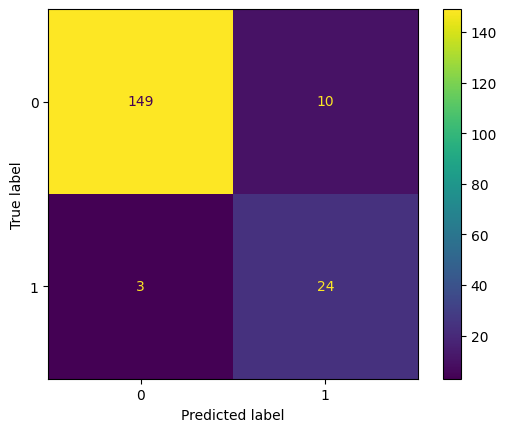

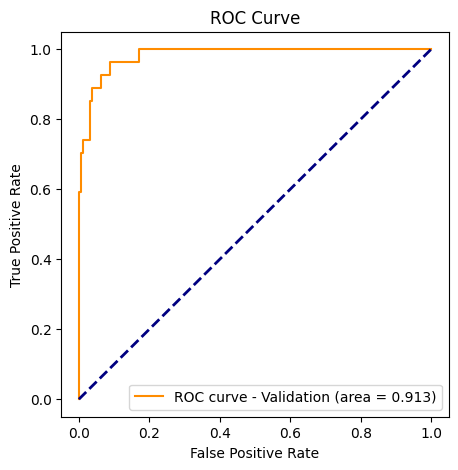

In [42]:
model_performance(xg_pred_test, xg_proba_test, y_test, 'XGBoost')

xg_roc_auc = metrics.roc_auc_score(y_test, xg_pred_test, labels=['0','1'])

Scoring Metrics for LGBM (Validation)
Balanced Accuracy Score = 0.901
Accuracy Score = 0.962
Precision Score = 0.917
F1 Score = 0.863
Recall Score = 0.815
ROC AUC Score = 0.901
Confusion Matrix
[[157   2]
 [  5  22]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       159
           1       0.92      0.81      0.86        27

    accuracy                           0.96       186
   macro avg       0.94      0.90      0.92       186
weighted avg       0.96      0.96      0.96       186

======= ROC Curve =======


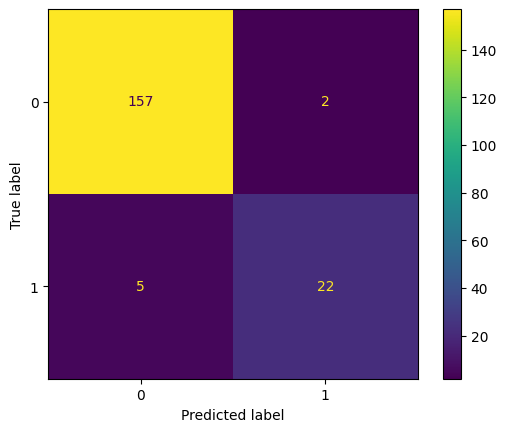

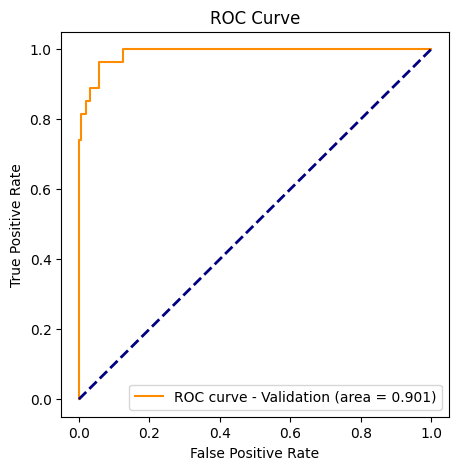

In [43]:
model_performance(lgbm_pred_test, lgbm_proba_test, y_test, 'LGBM')

lgbm_roc_auc = metrics.roc_auc_score(y_test, lgbm_pred_test, labels=['0','1'])

Scoring Metrics for Logistic Regression (Validation)
Balanced Accuracy Score = 0.876
Accuracy Score = 0.919
Precision Score = 0.688
F1 Score = 0.746
Recall Score = 0.815
ROC AUC Score = 0.876
Confusion Matrix
[[149  10]
 [  5  22]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       159
           1       0.69      0.81      0.75        27

    accuracy                           0.92       186
   macro avg       0.83      0.88      0.85       186
weighted avg       0.93      0.92      0.92       186

======= ROC Curve =======


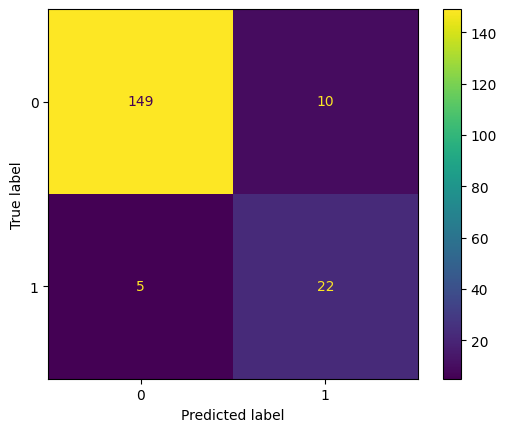

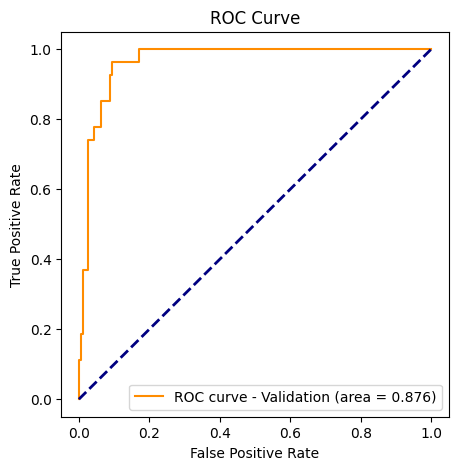

In [44]:
model_performance(logreg_pred_test, logreg_proba_test, y_test, 'Logistic Regression')

logreg_roc_auc = metrics.roc_auc_score(y_test, logreg_pred_test, labels=['0','1'])

# 4.5 Model Explanation

In [45]:
def model_explanation (model_name, name):
    importances = model_name.feature_importances_
    top_indices = importances.argsort()[::-1][:20]
    top_feature_names = X_smote.columns[top_indices]
    top_importances = importances[top_indices]

    plt.figure(figsize = (10, 6))
    plt.bar(range(len(top_feature_names)), top_importances)
    plt.xticks(range(len(top_feature_names)), top_feature_names, rotation = 90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Top 20 Feature Importance - ' + name)
    plt.tight_layout()
    plt.show()

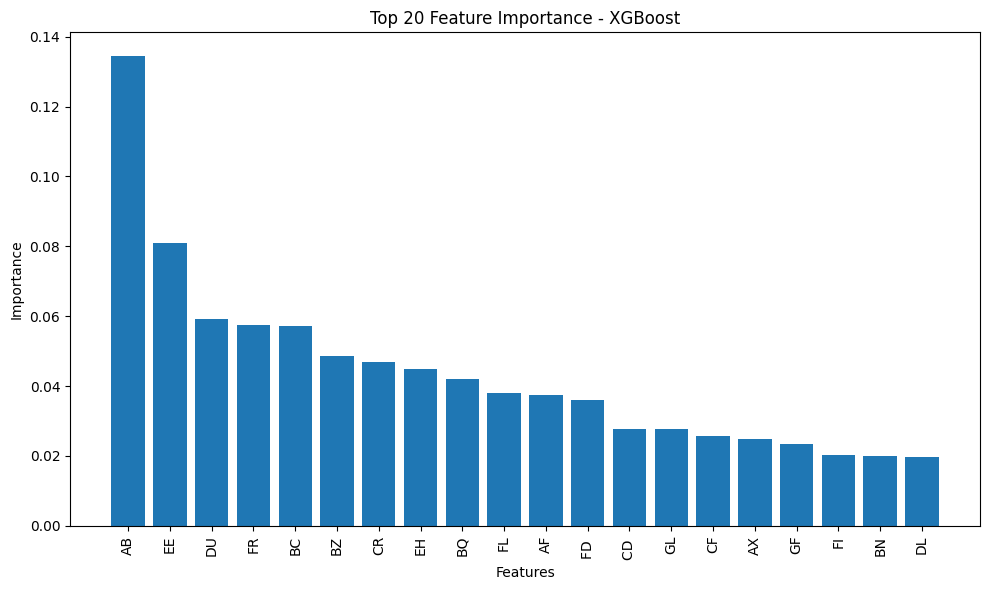

In [46]:
model_explanation(best_xgb, 'XGBoost')

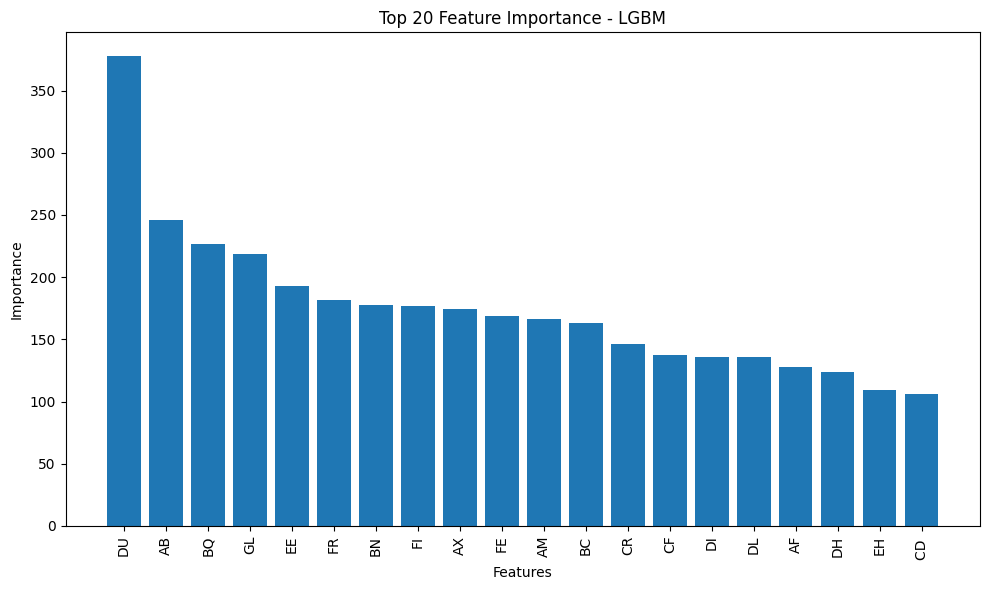

In [47]:
model_explanation(best_lgbm, 'LGBM')

# 4.6. Prediction and Submission

In [48]:
xg_pred = xg_model.predict_proba(df_test_2.drop(['Id'], axis=1))
print('========== XGBoost ==========')
print(xg_pred)

lgbm_pred = lgbm_model.predict_proba(df_test_2.drop(['Id'], axis=1))
print('========== LGBM ==========')
print(lgbm_pred)

logreg_pred = logreg_model.predict_proba(df_test_2.drop(['Id'], axis=1))
print('========== Logistic Regression ==========')
print(logreg_pred)


========== XGBoost ==========
[[0.92256963 0.07743034]
 [0.92256963 0.07743034]
 [0.92256963 0.07743034]
 [0.92256963 0.07743034]
 [0.92256963 0.07743034]]
========== LGBM ==========
[[9.99994537e-01 5.46255114e-06]
 [9.99994537e-01 5.46255114e-06]
 [9.99994537e-01 5.46255114e-06]
 [9.99994537e-01 5.46255114e-06]
 [9.99994537e-01 5.46255114e-06]]
========== Logistic Regression ==========
[[0.37195625 0.62804375]
 [0.37195625 0.62804375]
 [0.37195625 0.62804375]
 [0.37195625 0.62804375]
 [0.37195625 0.62804375]]


In [49]:
xg_weight = xg_roc_auc/(lgbm_roc_auc + xg_roc_auc + logreg_roc_auc)
lgbm_weight = lgbm_roc_auc/(lgbm_roc_auc + xg_roc_auc + logreg_roc_auc)
logreg_weight = logreg_roc_auc/(lgbm_roc_auc + xg_roc_auc + logreg_roc_auc)

print('Weight of XGBoost : {}, Weight of LGBM : {}, Weight of Reg : {}'.format(xg_weight, lgbm_weight, logreg_weight))

Weight of XGBoost : 0.33939472658786857, Weight of LGBM : 0.33497856864527864, Weight of Reg : 0.32562670476685285
